In [1]:
import pandas as pd
import numpy as np
import h5py
import pylab as P
from IPython.display import display, display_pretty, Javascript, HTML
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#pd.options.display.float_format = '{:.1f}%'.format 

In [3]:
#base
survey = h5py.File(r'R:\SoundCast\estimation\2014\P5\skims_attached\survey14.h5','r+')
base_name = '2014 Survey'

In [4]:
#scen
daysim = h5py.File('R:/SoundCast/releases/TransportationFutures2010/outputs/daysim_outputs.h5','r+')
scen_name = 'Daysim'

In [5]:
def build_df(h5file, h5table, var_dict, survey_file=False):
    ''' Convert H5 into dataframe '''
    data = {}
    if survey_file:
        # survey h5 have nested data structure, different than daysim_outputs
        for col_name, var in var_dict.iteritems():
            data[col_name] = [i[0] for i in h5file[h5table][var][:]]
    else:
        for col_name, var in var_dict.iteritems():
            data[col_name] = [i for i in h5file[h5table][var][:]]
 
    return pd.DataFrame(data)


#where daysim= an h5 file you�ve read into memory already, and survey_file can be true or false, 
#depending on if the data is stored as an array or as scalar


In [6]:
tripdict={'Household ID': 'hhno',
            'Person Number': 'pno',
            'Travel Time':'travtime',
            'Travel Cost': 'travcost',
            'Travel Distance': 'travdist',
            'Mode': 'mode',
            'Purpose (destination)':'dpurp',
            'Purpose (origin)':'opurp',
            'Departure Time': 'deptm',
            'Origin TAZ': 'otaz',
            'Destination TAZ': 'dtaz',
            'Destination Parcel': 'dpcl',
            'Departure Time': 'deptm',
            'Expansion Factor_tp': 'trexpfac'}


In [7]:
trip_survey = build_df(h5file=survey, h5table='Trip', var_dict=tripdict, survey_file=False)

In [8]:
trip_daysim = build_df(h5file=daysim, h5table='Trip', var_dict=tripdict, survey_file=False)

In [9]:
len(np.unique(trip_survey['Destination TAZ']))

3268

In [10]:
len(np.unique(trip_daysim['Destination TAZ']))

3756

# Functions for comparison

In [11]:
# Select all home -> work and work -> trips
def get_work_trips(df):
    
    # home to work trips
    work2home = df[df['Purpose (origin)'] == 1]    # select all work destination
    work2home = work2home[work2home['Purpose (destination)'] == 0]    # select all home origins

    # work to home trips
    home2work = df[df['Purpose (origin)'] == 0]    # select all work destination
    home2work = home2work[home2work['Purpose (destination)'] == 1]   # select all home origins

    # all work trips
    work_trips = work2home.append(home2work)
    
    return work_trips

In [12]:
def wt_mean(df, measure_col, weight_col, groupby_field=None):
    '''Compute weighted statistic for a dataframe'''
    
    if groupby_field:
        #df['weighted'] = df[measure_col]*df[weight_col]
        result_df = df.groupby(groupby_field).sum()['weighted']/df.sum()[weight_col]
    else:
        #print (df[measure_col]*df[weight_col]).sum()
        #print df[weight_col].sum()
        result_df = (df[measure_col]*df[weight_col]).sum()/df[weight_col].sum()
    
    return result_df

# Trip length distribution plots for work, SOV mode

# region

In [13]:
work_trip_survey = get_work_trips(trip_survey)
work_trip_daysim = get_work_trips(trip_daysim)

In [14]:
work_trip_survey = work_trip_survey[work_trip_survey['Travel Distance'] > 0]
work_trip_daysim = work_trip_daysim[work_trip_daysim['Travel Distance'] > 0]

In [15]:
print base_name + ": " + str(wt_mean(df=work_trip_survey, 
                                     measure_col='Travel Distance', 
                                     weight_col='Expansion Factor_tp')/100)
print scen_name + ": " + str(wt_mean(df=work_trip_daysim, 
                                     measure_col='Travel Distance', 
                                     weight_col='Expansion Factor_tp'))

2014 Survey: 11.7616553021
Daysim: 13.489142888


In [16]:
len(work_trip_survey)

5573

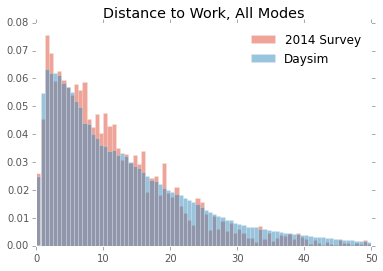

In [17]:
(work_trip_survey['Travel Distance']/100).hist(bins=80, normed=True,
                                              weights=work_trip_survey['Expansion Factor_tp'].values,
                                             alpha=0.5, range=[0,50],
                                             label=base_name)

(work_trip_daysim['Travel Distance']).hist(bins=80, normed=True,
                                             alpha=0.5, range=[0,50],
                                             label=scen_name)



plt.legend(loc='upper right')
plt.title('Distance to Work, All Modes')

In [18]:
work_sov_trip_survey = work_trip_survey[work_trip_survey['Mode'] == 3]
work_sov_trip_daysim = work_trip_daysim[work_trip_daysim['Mode'] == 3]

In [19]:
np.unique(work_trip_survey.Mode)

array([3, 4, 5], dtype=int64)

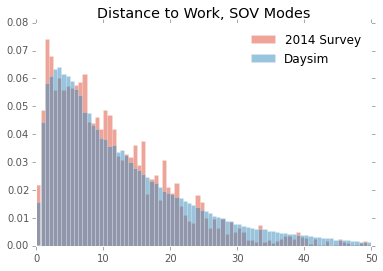

In [20]:
(work_sov_trip_survey['Travel Distance']/100).hist(bins=80, normed=True,
                                              weights=work_sov_trip_survey['Expansion Factor_tp'].values,
                                             alpha=0.5, range=[0,50],
                                             label=base_name)

(work_sov_trip_daysim['Travel Distance']).hist(bins=80, normed=True,
                                             alpha=0.5, range=[0,50],
                                             label=scen_name)



plt.legend(loc='upper right')
plt.title('Distance to Work, SOV Modes')

# BKR 

In [21]:
BKR = pd.read_csv(r'H:\data request\bellevue\BKR_TAZ_2010.txt')

In [22]:
BKR_work_trip_daysim = pd.merge(work_trip_daysim, BKR, left_on='Destination TAZ', right_on='TAZ')
BKR_work_trip_survey = pd.merge(work_trip_survey, BKR, left_on='Destination TAZ', right_on='TAZ')

In [23]:
print base_name + ": " + str(wt_mean(df=BKR_work_trip_survey, 
                                     measure_col='Travel Distance', 
                                     weight_col='Expansion Factor_tp')/100)
print scen_name + ": " + str(wt_mean(df=BKR_work_trip_daysim, 
                                     measure_col='Travel Distance', 
                                     weight_col='Expansion Factor_tp'))

2014 Survey: 10.7941931403
Daysim: 10.9748747955


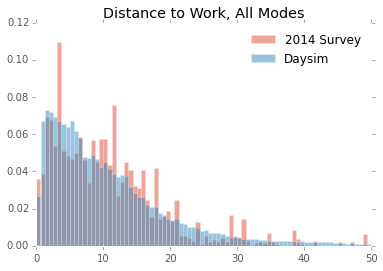

In [24]:
(BKR_work_trip_survey['Travel Distance']/100).hist(bins=80, normed=True,
                                              weights=BKR_work_trip_survey['Expansion Factor_tp'].values,
                                             alpha=0.5, range=[0,50],
                                             label=base_name)

(BKR_work_trip_daysim['Travel Distance']).hist(bins=80, normed=True,
                                             alpha=0.5, range=[0,50],
                                             label=scen_name)

plt.legend(loc='upper right')
plt.title('Distance to Work, All Modes')

In [25]:
BKR_work_sov_trip_daysim = pd.merge(work_sov_trip_daysim, BKR, left_on='Destination TAZ', right_on='TAZ')
BKR_work_sov_trip_survey = pd.merge(work_sov_trip_survey, BKR, left_on='Destination TAZ', right_on='TAZ')

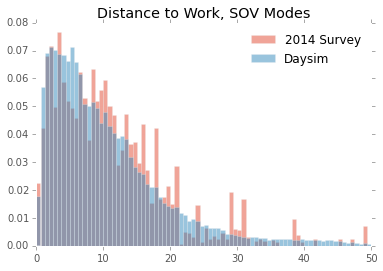

In [26]:
(BKR_work_sov_trip_survey['Travel Distance']/100).hist(bins=80, normed=True,
                                              weights=BKR_work_sov_trip_survey['Expansion Factor_tp'].values,
                                             alpha=0.5, range=[0,50],
                                             label=base_name)

(BKR_work_sov_trip_daysim['Travel Distance']).hist(bins=80, normed=True,
                                             alpha=0.5, range=[0,50],
                                             label=scen_name)

plt.legend(loc='upper right')
plt.title('Distance to Work, SOV Modes')

Basic statistics